In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Polynomial interpolation with Chebyshev nodes extrema of T_{n}(x)

def ChebSum2_Clenshaw_matrix(n,x,c):
    diagonals = [np.ones((n+1,)),-2*x*np.ones((n,)),np.ones((n-1,))]
    A = scipy.sparse.diags(diagonals,[0,-1,-2],shape=(n+1,n+1))
    A = A.toarray()
    b = scipy.linalg.solve_triangular(np.transpose(A),c,lower = False) # Upper-triangular solver
    return 0.5*(b[0] - b[2] - b[n]*np.cos(n*np.arccos(x)))
    
   
def cheb(N):
    if N == 0: return np.array([[0.]]), np.array([1.])
    x = np.cos(np.pi*np.arange(N+1)/N)
    c = np.ones(N+1); c[0]=c[-1]=2; c *= (-1.0)**np.arange(N+1)
    X = np.tile(x,(N+1,1)); dX = X - X.T
    D = (np.outer(c,1/c)) / (dX + np.eye(N+1))
    D -= np.diag(np.sum(D,axis=1))
    return D, x

def u_exact(x): return np.cos(np.pi*x) + 1.0
def u_xx(x):    return -np.pi**2*np.cos(np.pi*x)
def u_xxxx(x):  return  np.pi**4*np.cos(np.pi*x)

def solve_bvp(N):
    D, x = cheb(N)
    I  = np.eye(N+1)
    D2 = D @ D
    D4 = D2 @ D2
    L  = D4 - 4*D2 + 3*I
    g  = u_xxxx(x) - 4*u_xx(x) + 3*u_exact(x)
    # enforce u(-1)=0, u'(-1)=0, u(1)=0, u'(1)=0
    L[0,:]=0;   L[0,0]=1;    g[0]=0
    L[1,:]=D[0,:];           g[1]=0
    L[-2,:]=0;  L[-2,-1]=1;  g[-2]=0
    L[-1,:]=D[-1,:];         g[-1]=0
    u = np.linalg.solve(L, g)
    return x, u

def nodes_to_cheb_coeffs_extrema(u):  # DCT-I with half weights
    N = len(u)-1
    t = (np.arange(N+1))*np.pi/N
    c = np.zeros(N+1)
    for k in range(N+1):
        c[k] = (2*np.sum(u*np.cos(k*t)) - u[0]*np.cos(k*t[0]) - u[-1]*np.cos(k*t[-1]))/N
    return c


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


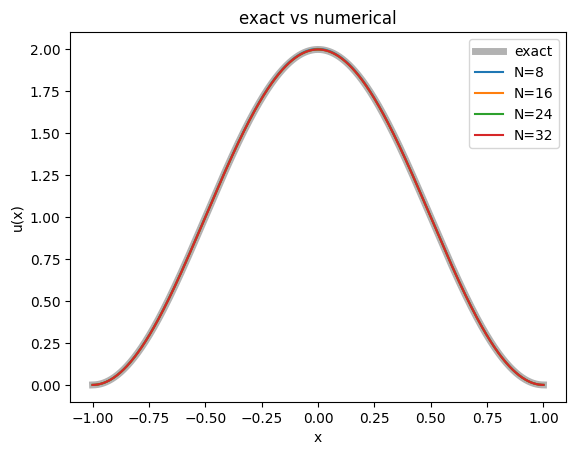

In [2]:
xf = np.linspace(-1,1,1000)
N_list = [8,16,24,32]
plt.figure()
plt.plot(xf, u_exact(xf), label='exact', lw=5, alpha=0.3, color='black')
for N in N_list:
    x,u = solve_bvp(N)
    c   = nodes_to_cheb_coeffs_extrema(u)
    u_smooth = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    plt.plot(xf, u_smooth, label=f'N={N}')

plt.legend()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('exact vs numerical')
plt.show()


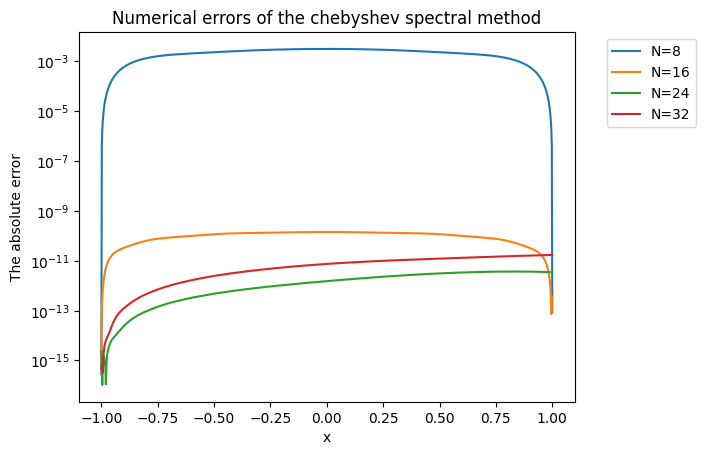

In [3]:
# Cheyshev Nodes error versus x at different N

for N in N_list:
    x, u = solve_bvp(N)
    c = nodes_to_cheb_coeffs_extrema(u)
    u_smooth = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    uf = u_exact(xf)
    err = np.abs(u_smooth - uf)
    plt.plot(xf, err, label=f'N={N}')
plt.yscale('log')
plt.title('Numerical errors of the chebyshev spectral method')
plt.xlabel('x')
plt.ylabel('The absolute error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



No luck :(. N=4, max error = 1.3229636026145912
No luck :(. N=6, max error = 0.0675420274045122
No luck :(. N=8, max error = 0.003165560059803063
No luck :(. N=10, max error = 7.288955146367293e-05
No luck :(. N=12, max error = 1.2599726966211477e-06
No luck :(. N=14, max error = 1.498187152115804e-08
No luck :(. N=16, max error = 1.4171908091498153e-10
No luck :(. N=18, max error = 2.1402879468723768e-12
No luck :(. N=20, max error = 4.3535780136471616e-12
No luck :(. N=22, max error = 9.885425811262394e-13
No luck :(. N=24, max error = 3.683719995706269e-12
No luck :(. N=26, max error = 1.480693345712325e-11
No luck :(. N=28, max error = 1.1284728177368541e-11
No luck :(. N=30, max error = 1.7026158261046476e-11
No luck :(. N=32, max error = 1.704272126256516e-11
No luck :(. N=34, max error = 1.4568447670859445e-11
No luck :(. N=36, max error = 1.1583567438577802e-11
No luck :(. N=38, max error = 2.960221774392084e-11
No luck :(. N=40, max error = 2.384092923080061e-11
No luck :(. N=

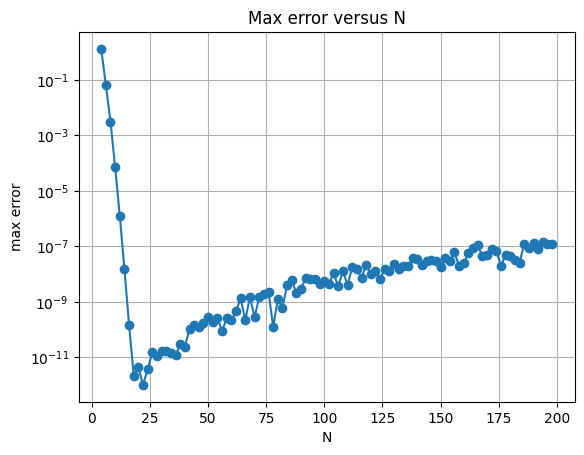

In [4]:
# Determine what N do you need to take to achieve a machine precision.

machine_epsilon = np.finfo(np.float64).eps
N_list = np.arange(4,200,2)
err_max = np.zeros(len(N_list))
for i,N in enumerate(N_list):
    x,u = solve_bvp(N)
    c = nodes_to_cheb_coeffs_extrema(u)
    u_smooth = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    uf = u_exact(xf)
    err = np.abs(u_smooth - uf)
    err_max[i] = np.max(err)
    if err_max[i] < machine_epsilon:
        print(f'Machine precision {machine_epsilon} is achieved at N={N}')
        break
    else:
        print(f'N={N}, max error = {err_max[i]}')
plt.semilogy(N_list, err_max, 'o-')
plt.xlabel('N')
plt.ylabel('max error')
plt.title('Max error versus N')
plt.grid()

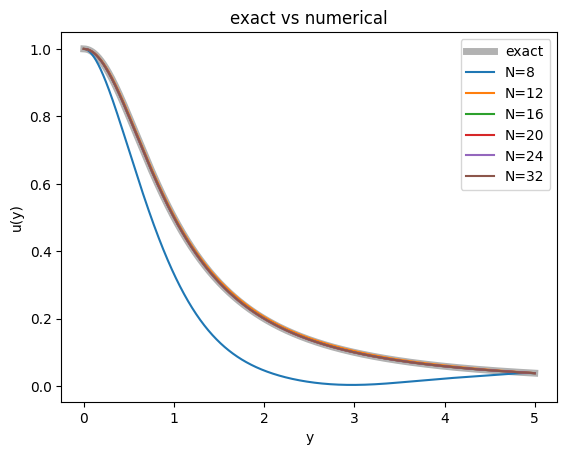

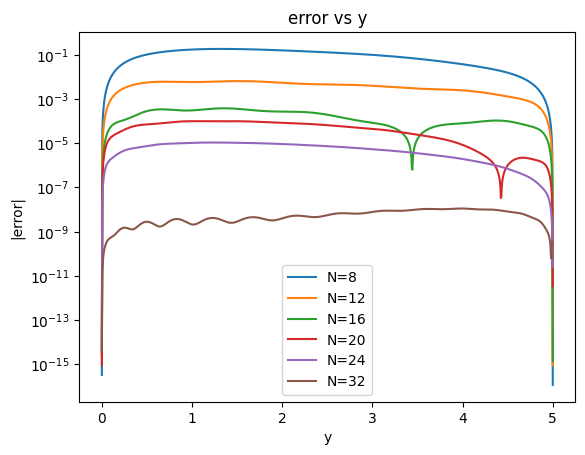

In [8]:

def cheb_good(N):
    if N == 0: return np.array([[0.]]), np.array([1.])
    x = np.cos(np.pi*np.arange(N+1)/N) # Chebyshev nodes extrema
    c = np.ones(N+1)
    c[0]=2; c[-1]=2 # weights
    c *= (-1.0)**np.arange(N+1) # alternating signs
    X = np.tile(x,(N+1,1)) # meshgrid
    dX = X - X.T # pairwise differences
    D = (np.outer(c,1/c)) / (dX + np.eye(N+1)) # off-diagonal entries
    D -= np.diag(np.sum(D,axis=1)) # diagonal entries
    return -D, x  # flip sign so D@x = 1

def solve_q6_fixed(N):
    D, x = cheb_good(N) # derivative wrt x
    y = (5.0)*(x + 1)/2.0
    I  = np.eye(N+1)
    s1 = 2.0/5.0
    D1y = s1*D
    D4y = (s1**4)*((D@D)@(D@D))
    L = D4y + D1y + I
    g = (24 - 240*y**2 + 120*y**4)/(1 + y**2)**5 + 1/(1 + y**2) - 2*y/(1 + y**2)**2
    # BC rows
    L[0,:] = 0.0
    L[0,0] = 1.0
    g[0] = 1.0/26.0
    L[1,:] = D1y[0,:]
    g[1] = -10.0/676.0
    L[-2,:] = 0.0
    L[-2,-1] = 1.0
    g[-2] = 1.0
    L[-1,:] = D1y[-1,:]
    g[-1] = 0.0
    u = np.linalg.solve(L, g)
    return y, u

# Plot exact vs numerical
yf = np.linspace(0, 5, 1000)
uf = 1/(1+yf**2) # exact solution

plt.figure()
plt.plot(yf, uf, label='exact', lw=5, alpha=0.3, color='black')
for N in [8, 12, 16, 20, 24, 32]:
    y, u = solve_q6_fixed(N)
    c = nodes_to_cheb_coeffs_extrema(u)
    xf = (2*yf - 5.0)/(5.0)  # x from y
    u_s = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    plt.plot(yf, u_s, label=f'N={N}')
plt.legend()
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('exact vs numerical')
plt.show()

# Error curves
plt.figure()
for N in [8, 12, 16, 20, 24, 32]:
    y, u = solve_q6_fixed(N)
    c = nodes_to_cheb_coeffs_extrema(u)
    xf = (2*yf - 5.0)/5.0
    u_s = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    err = np.abs(u_s - uf)
    plt.semilogy(yf, err, label=f'N={N}')
plt.legend(); plt.xlabel('y'); plt.ylabel('|error|'); plt.title('error vs y'); plt.show()





N=4, max error = 0.4728932817498092
N=6, max error = 0.22572734481707135
N=8, max error = 0.17889783609433427
N=10, max error = 0.018655135822244096
N=12, max error = 0.006285511340066052
N=14, max error = 0.004017111905210702
N=16, max error = 0.0003709706603997609
N=18, max error = 0.0003367289939947282
N=20, max error = 9.716722324881744e-05
N=22, max error = 9.389646145996355e-06
N=24, max error = 1.0562510819489557e-05
N=26, max error = 1.4081944373911526e-06
N=28, max error = 6.195529596020322e-07
N=30, max error = 2.4584844804387274e-07
N=32, max error = 1.1043649522646248e-08
N=34, max error = 2.0939644018724834e-08
N=36, max error = 4.006001974588003e-09
N=38, max error = 9.158354630223187e-10
N=40, max error = 1.1359668344868012e-09
N=42, max error = 8.704613585486243e-09
N=44, max error = 5.8030932767461074e-09
N=46, max error = 1.5628716300286616e-08
N=48, max error = 2.630502357603426e-09
N=50, max error = 3.1985603339557134e-08
N=52, max error = 5.692746322949471e-09
N=54

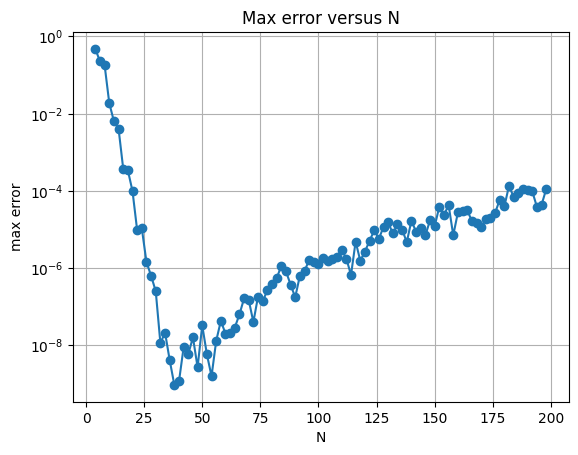

In [7]:
# Determine what N do you need to take to achieve a machine precision.

machine_epsilon = np.finfo(np.float64).eps
N_list = np.arange(4,200,2)
err_max = np.zeros(len(N_list))
for i,N in enumerate(N_list):
    y,u = solve_q6_fixed(N)
    c = nodes_to_cheb_coeffs_extrema(u)
    xf = (2*yf - 5.0)/5.0
    u_s = np.array([ChebSum2_Clenshaw_matrix(N, xv, c) for xv in xf])
    err = np.max(np.abs(u_s - uf))
    err_max[i] = np.max(err)
    if err_max[i] < machine_epsilon:
        print(f'Machine precision {machine_epsilon} is achieved at N={N}')
        break
    else:
        print(f'N={N}, max error = {err_max[i]}')
plt.semilogy(N_list, err_max, 'o-')
plt.xlabel('N')
plt.ylabel('max error')
plt.title('Max error versus N')
plt.grid()